# Satellite Imagery Classification using Attention-based Deep MIL

Date: 27/04/2025  

Aristotle University of Thessaloniki  

MSc in Artificial Intelligence

## Import Libraries

In [2]:
import numpy as np
import keras
from keras import layers, ops
from tqdm import tqdm
from matplotlib import pyplot as plt
import gdown
import requests
import os
import yaml
import random

# Set the seed for random function of python
random.seed(1)

## Unzip Bags dataset

In [3]:
# unzip fetched dataset
!unzip -q /content/drive/MyDrive/VIIRS/bagsAugmented.zip -d /content/

## Collect GDB statistics

In [4]:
url = "https://raw.githubusercontent.com/pleleGit/SatSenseAI/main/statistics/gdbBinary.yaml"
response = requests.get(url)

with open("gdbBinary.yaml", "wb") as f:
    f.write(response.content)

## Create & Import Bags

In [5]:
# load gdbBinary.yaml
with open("gdbBinary.yaml", "r") as f:
    gdbBinary = yaml.safe_load(f)

In [6]:
gdb = gdbBinary["gdp_per_capita_index"]

In [7]:
# load custom Bags dataset for training with Keras
train_bags = []
val_bags = []
test_bags = []
dataset_path = "/content/bagsAugmented"
instances_count = 50
train_bags_labels = []
val_bags_labels = []
test_bags_labels = []
countries = sorted(os.listdir(dataset_path))
years = sorted(os.listdir(os.path.join(dataset_path, countries[0])))
print(f"Countries: {countries}")
print(f"Bags per year: {years}")
train_countries = random.sample(countries, 12)
for i, country in enumerate(countries):
    val_year = random.sample(years, 2)
    for year_bag in years:
        bag = []
        # Get the list of files
        all_files = os.listdir(os.path.join(dataset_path, country, year_bag))
        # Pick 30 random files without replacement
        selected_files = random.sample(all_files, instances_count)
        for img_path in selected_files:
            # Loads each image into PIL format
            img = keras.preprocessing.image.load_img(os.path.join(dataset_path, country, year_bag, img_path),
                                                    target_size=(300, 225),
                                                    color_mode="grayscale")
            # Converts a PIL Image instance to a NumPy array
            img_array = keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  # standardize image to [0, 1]
            bag.append(img_array)
            if len(bag) == instances_count:
                break
        # collect the corresponding gdp per capita index
        id = int(year_bag[1:]) - 14
        if country in train_countries:
            if year_bag in val_year:
                val_bags.append(bag)
                val_bags_labels.append([gdb[country][id]])
            else:
                train_bags.append(bag)
                train_bags_labels.append([gdb[country][id]])
        else:
            test_bags.append(bag)
            test_bags_labels.append([gdb[country][id]])
train_bags = np.squeeze(np.swapaxes(np.array(train_bags), 0, 1))
train_bags_labels = np.array(train_bags_labels)
val_bags = np.squeeze(np.swapaxes(np.array(val_bags), 0, 1))
val_bags_labels = np.array(val_bags_labels)
test_bags = np.squeeze(np.swapaxes(np.array(test_bags), 0, 1))
test_bags_labels = np.array(test_bags_labels)

Countries: ['Albania', 'Austria', 'Belgium', 'Bosnia', 'Bulgaria', 'England', 'FYROM', 'France', 'Germany', 'Greece', 'Hungary', 'Italy', 'Montenegro', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Spain']
Bags per year: ['b14', 'b15', 'b16', 'b17', 'b18', 'b19', 'b20', 'b21', 'b22', 'b23']


In [8]:
print("~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~")
print(f"Bags Shape: {train_bags.shape}")
print(f"Number of Bags: {train_bags.shape[1]}")
print(f"Number of Instances per Bag: {train_bags.shape[0]}")
print(f"Shape of each Instance: {train_bags.shape[2:]}")
print(f"Shape of Labels: {train_bags_labels.shape}")
print("~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~")
print(f"Bags Shape: {val_bags.shape}")
print(f"Number of Bags: {val_bags.shape[1]}")
print(f"Number of Instances per Bag: {val_bags.shape[0]}")
print(f"Shape of each Instance: {val_bags.shape[2:]}")
print(f"Shape of Labels: {val_bags_labels.shape}")
print("~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~")
print(f"Bags Shape: {test_bags.shape}")
print(f"Number of Bags: {test_bags.shape[1]}")
print(f"Number of Instances per Bag: {test_bags.shape[0]}")
print(f"Shape of each Instance: {test_bags.shape[2:]}")
print(f"Shape of Labels: {test_bags_labels.shape}")
train_bags = list(train_bags)
val_bags = list(val_bags)
test_bags = list(test_bags)

~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~
Bags Shape: (50, 96, 300, 225)
Number of Bags: 96
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (96, 1)
~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~
Bags Shape: (50, 24, 300, 225)
Number of Bags: 24
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (24, 1)
~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~
Bags Shape: (50, 70, 300, 225)
Number of Bags: 70
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (70, 1)


In [9]:
print(f"Positive / Negative Bags in train set: {np.sum(train_bags_labels)} / {train_bags_labels.shape[0] - np.sum(train_bags_labels)}")
print(f"Positive / Negative Bags in validation set: {np.sum(val_bags_labels)} / {val_bags_labels.shape[0] - np.sum(val_bags_labels)}")
print(f"Positive / Negative Bags in test set: {np.sum(test_bags_labels)} / {test_bags_labels.shape[0] - np.sum(test_bags_labels)}")

Positive / Negative Bags in train set: 61 / 35
Positive / Negative Bags in validation set: 14 / 10
Positive / Negative Bags in test set: 35 / 35


## Prepare the MIL Attention layer

In [12]:
class MILAttentionLayer(layers.Layer):
    def __init__(self, weight_dim, kernel_init="glorot_uniform", kernel_reg="None", use_gated=False, **kwargs):
        super().__init__(**kwargs)
        self.weight_dim = weight_dim  # dimension of the weight matrix
        self.use_gated = use_gated  # to enable/disable gated mechanism
        self.kernel_init = keras.initializers.get(kernel_init)
        self.kernel_reg = keras.regularizers.get(kernel_reg)

        self.v_init = self.kernel_init
        self.w_init = self.kernel_init
        self.u_init = self.kernel_init

        self.v_reg = self.kernel_reg
        self.w_reg = self.kernel_reg
        self.u_reg = self.kernel_reg

    def build(self, input_shape):
        # Input shape.
        # List of 2D tensors with shape: (batch_size, input_dim).
        input_dim = input_shape[0][1]
        self.v_weight_params = self.add_weight(
            shape=(input_dim, self.weight_dim),
            initializer=self.v_init,
            name="v",
            regularizer=self.v_reg,
            trainable=True,
        )
        self.w_weight_params = self.add_weight(
            shape=(self.weight_dim, 1),
            initializer=self.w_init,
            name="w",
            regularizer=self.w_reg,
            trainable=True,
        )
        if self.use_gated:
            self.u_weight_params = self.add_weight(
                shape=(input_dim, self.weight_dim),
                initializer=self.u_init,
                name="u",
                regularizer=self.u_reg,
                trainable=True,
            )
        else:
            self.u_weight_params = None
        self.input_built = True

    def call(self, inputs):
        # Assigning variables from the number of inputs.
        instances = [self.compute_attention_scores(instance) for instance in inputs]
        # Stack instances into a single tensor.
        instances = ops.stack(instances)
        # Apply softmax over instances such that the output summation is equal to 1.
        alpha = ops.softmax(instances, axis=0)
        # Split to recreate the same array of tensors we had as inputs.
        return [alpha[i] for i in range(alpha.shape[0])]

    def compute_attention_scores(self, instance):
        # Reserve in-case "gated mechanism" used.
        original_instance = instance
        # tanh(v*h_k^T)
        instance = ops.tanh(ops.tensordot(instance, self.v_weight_params, axes=1))
        # for learning non-linear relations efficiently.
        if self.use_gated:
            instance = instance * ops.sigmoid(
                ops.tensordot(original_instance, self.u_weight_params, axes=1)
            )
        # w^T*(tanh(v*h_k^T)) / w^T*(tanh(v*h_k^T)*sigmoid(u*h_k^T))
        return ops.tensordot(instance, self.w_weight_params, axes=1)

## Create Model

In [13]:
def create_model(instance_shape):
    # Extract features from inputs.
    inputs, embeddings = [], []
    dense_layer_1 = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.L2(0.02))
    dense_layer_2 = layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.L2(0.02))
    for _ in range(instances_count):
        inp = layers.Input(instance_shape)
        flatten = layers.Flatten()(inp)
        dense_1 = dense_layer_1(flatten)
        dense_2 = dense_layer_2(dense_1)
        inputs.append(inp)
        embeddings.append(dense_2)
    # Invoke the attention layer.
    alpha = MILAttentionLayer(
        weight_dim=256,
        kernel_reg=keras.regularizers.L2(0.02),
        use_gated=True,
        name="alpha",
    )(embeddings)
    # Multiply attention weights with the input layers.
    multiply_layers = [
        layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))
    ]
    # Concatenate layers.
    concat = layers.concatenate(multiply_layers, axis=1)
    # Classification output node.
    output = layers.Dense(2, activation="softmax")(concat)
    return keras.Model(inputs, output)

## Compute Class Weights based on their frequency

In [14]:
def compute_class_weights(labels):
    # Count number of positive and negative bags.
    negative_count = len(np.where(labels == 0)[0])
    positive_count = len(np.where(labels == 1)[0])
    total_count = negative_count + positive_count
    # Build class weight dictionary.
    return {
        0: (1 / negative_count) * (total_count / 2),
        1: (1 / positive_count) * (total_count / 2),
    }

## Build and train the model

In [15]:
def plot_learning_curves(history, model_idx=0):
    """Plot training and validation loss/accuracy."""
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    # Loss plot
    axs[0].plot(history.history["loss"], label="Train Loss")
    axs[0].plot(history.history["val_loss"], label="Val Loss")
    axs[0].set_title(f"Model {model_idx} - Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid()
    # Accuracy plot
    axs[1].plot(history.history["accuracy"], label="Train Accuracy")
    axs[1].plot(history.history["val_accuracy"], label="Val Accuracy")
    axs[1].set_title(f"Model {model_idx} - Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid()
    plt.show()

In [ ]:
def train(train_data, train_labels, val_data, val_labels, model, model_idx=0):
    """Train a model with callbacks, better logging, and plots."""

    # Create a clean temp folder
    os.makedirs("/tmp", exist_ok=True)
    file_path = f"/tmp/best_model_{model_idx}.weights.h5"

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            file_path,
            monitor="val_loss",
            verbose=1,
            mode="min",
            save_best_only=True,
            save_weights_only=True,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
            verbose=1,
            mode="min",
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            verbose=1,
            mode="min",
            min_lr=1e-6,
        )
    ]
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    # Train model
    history = model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=50,
        class_weight=compute_class_weights(train_labels),
        batch_size=8,
        callbacks=callbacks,
        verbose=1,
    )
    # Load best weights
    model.load_weights(file_path)
    # Plot learning curves
    plot_learning_curves(history, model_idx=model_idx)
    return model

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5465 - loss: 8.9998  
Epoch 1: val_loss improved from inf to 5.56069, saving model to /tmp/best_model_0.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.5466 - loss: 8.8716 - val_accuracy: 0.5417 - val_loss: 5.5607 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4262 - loss: 5.4517
Epoch 2: val_loss improved from 5.56069 to 4.46438, saving model to /tmp/best_model_0.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 346ms/step - accuracy: 0.4344 - loss: 5.4288 - val_accuracy: 0.5417 - val_loss: 4.4644 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6673 - loss: 4.1266
Epoch 3: val_loss improved from 4.46438 to 3.54493, saving model to /tmp/best_model_0.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.6663 - loss: 4.1156 - val_accuracy: 0.6667 - val_loss: 3.5449 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━

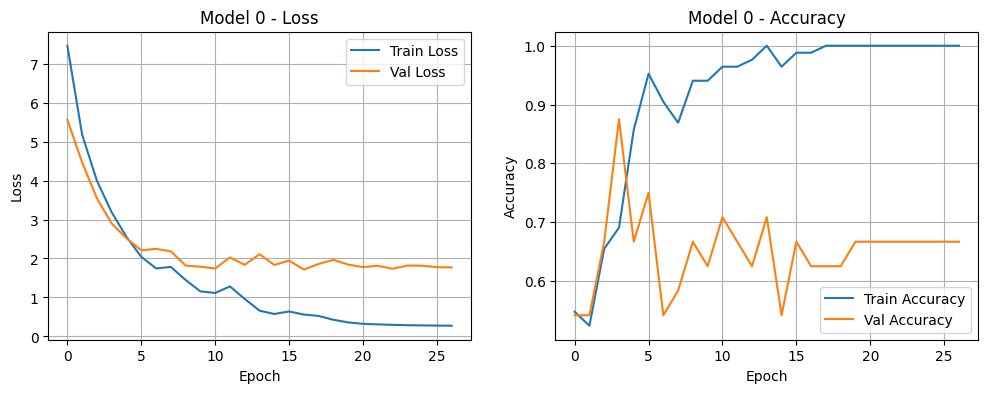

100%|██████████| 1/1 [02:19<00:00, 139.91s/it]


In [ ]:
ENSEMBLE_COUNT = 1
instance_shape = train_bags[0][0].shape
models = [create_model(instance_shape) for _ in range(ENSEMBLE_COUNT)]

trained_models = [
    train(train_bags, train_bags_labels, val_bags, val_bags_labels, model, idx)
    for idx, model in enumerate(tqdm(models))
]

In [ ]:
from google.colab import files
file_path = "/tmp/best_model_0.weights.h5"
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluate Trained Model

In [18]:
def predict(data, labels, trained_models):
    # Collect info per model.
    models_predictions = []
    models_attention_weights = []
    models_losses = []
    models_accuracies = []
    for model in trained_models:
        # Predict output classes on data.
        predictions = model.predict(data)
        models_predictions.append(predictions)
        # Create intermediate model to get MIL attention layer weights.
        intermediate_model = keras.Model(model.input, model.get_layer("alpha").output)
        # Predict MIL attention layer weights.
        intermediate_predictions = intermediate_model.predict(data)
        attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
        models_attention_weights.append(attention_weights)
        loss, accuracy = model.evaluate(data, labels, verbose=0)
        models_losses.append(loss)
        models_accuracies.append(accuracy)
    print(
        f"The average loss and accuracy are {np.sum(models_losses, axis=0) / ENSEMBLE_COUNT:.2f}"
        f" and {100 * np.sum(models_accuracies, axis=0) / ENSEMBLE_COUNT:.2f} % resp."
    )
    return (
        np.sum(models_predictions, axis=0) / ENSEMBLE_COUNT,
        np.sum(models_attention_weights, axis=0) / ENSEMBLE_COUNT,
    )

In [ ]:
# Evaluate and predict classes and attention scores on validation data.
class_predictions, attention_params = predict(test_bags, test_bags_labels, trained_models)

1/2 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step
The average loss and accuracy are 1.04 and 77.78 % resp.
